In [1]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import joblib

In [2]:
df = pd.read_csv('home_dataset.csv')
print("Dataset shape:", df.shape)
print(df.head())

house_sizes = df ['HouseSize'].values
house_prices = df['HousePrice'].values
assert "HouseSize" in df.columns and "HousePrice" in df.columns, "Expected columns 'HouseSize' and 'HousePrice'"

Dataset shape: (59, 2)
   HouseSize  HousePrice
0        793     1300000
1       2477     3700000
2       1263     1480000
3       1291     2380000
4        603      955000


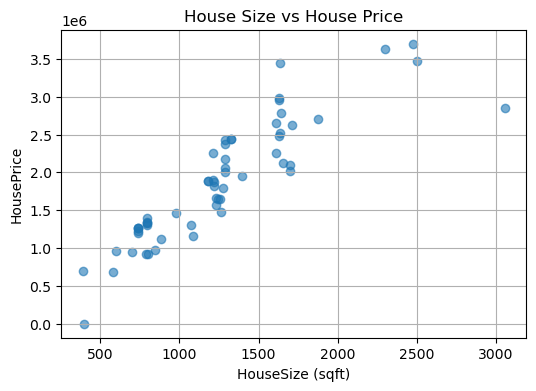

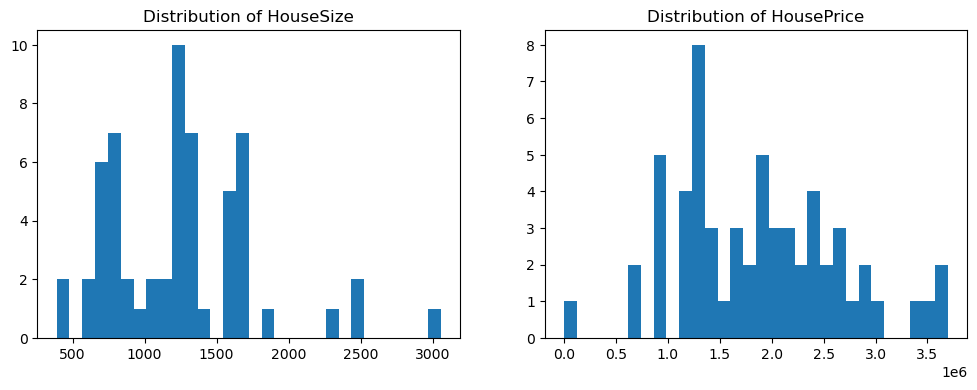

In [3]:
plt.figure(figsize=(6,4))
plt.scatter(df["HouseSize"], df["HousePrice"], alpha=0.6)
plt.title("House Size vs House Price")
plt.xlabel("HouseSize (sqft)")
plt.ylabel("HousePrice")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df["HouseSize"], bins=30)
plt.title("Distribution of HouseSize")
plt.subplot(1,2,2)
plt.hist(df["HousePrice"], bins=30)
plt.title("Distribution of HousePrice")
plt.show()


In [4]:
X = df[["HouseSize"]].values  # shape (n_samples, 1)
y = df["HousePrice"].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

Train size: 47 Test size: 12


In [6]:
models = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ]),
    "PolyDeg2_Linear": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ]),
    "PolyDeg3_Linear": Pipeline([
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ]),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}

In [ ]:
results = []
predictions = {}  # keep test predictions for plotting later

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Cross-validated RMSE on train (optional insight)
    if hasattr(model, "predict"):
        cv_scores = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        cv_rmse = -np.mean(cv_scores)
    else:
        cv_rmse = np.nan
    
    results.append({
        "model": name,
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "cv_rmse_train": cv_rmse
    })
    
results_df = pd.DataFrame(results).sort_values(by="rmse")
display(results_df.style.format({
    "r2":"{:.4f}",
    "mae":"{:.2f}",
    "rmse":"{:.2f}",
    "cv_rmse_train":"{:.2f}"
}))


In [9]:
# Choose the best model (lowest RMSE, highest R2)
results_df_sorted = results_df.sort_values(
    by=["rmse", "r2"],
    ascending=[True, False]
)

best_row = results_df_sorted.iloc[0]
best_model_name = best_row["model"]

print(f"\nBest model by RMSE: {best_model_name}")
best_model = models[best_model_name]



Best model by RMSE: LinearRegression


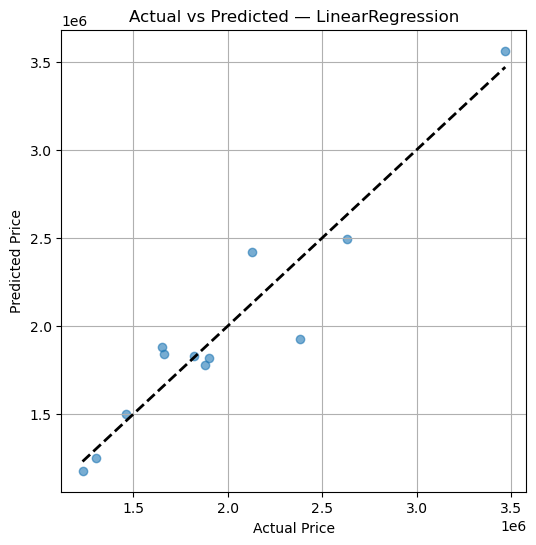

In [10]:
#Show prediction vs actual scatter for the best model
y_pred_best = predictions[best_model_name]

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted — {best_model_name}")
plt.grid(True)
plt.show()

In [12]:
joblib.dump(best_model, "best_model.pkl")
print("Saved best model to best_model.pkl")

Saved best model to best_model.pkl


In [14]:
def predict_price(size_in_sqft, model_path="best_model.pkl"):
    model = joblib.load(model_path)
    size_arr = np.array([[size_in_sqft]])
    pred = model.predict(size_arr)
    return float(pred[0])

# Quick test of prediction function
for s in [500, 800, 1200, 2000]:
    print(f"Predict price for {s} sqft: {predict_price(s):.2f}")

Predict price for 500 sqft: 852294.45
Predict price for 800 sqft: 1258897.85
Predict price for 1200 sqft: 1801035.71
Predict price for 2000 sqft: 2885311.45
